In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sys import path
path.append("/home/data1/musong/workspace/2025/8/08-20/spenpy")
from spenpy.spen import spen

def load_nii_slices(file_path, percent=0.3, rotate=True):
    """
    Load a NIfTI file, crop slices along the z-axis,
    and optionally rotate 90° anticlockwise.
    
    Args:
        file_path (str): Path to .nii or .nii.gz file.
        percent (float): Fraction to cut from both ends (0–0.5).
        rotate (bool): Whether to rotate slices 90° CCW.
        
    Returns:
        np.ndarray: Array of shape (b, w, h)
    """
    img = nib.load(file_path)
    data = img.get_fdata()
    data = np.asarray(data, dtype=np.float32)

    # Crop along z
    z_start = int(percent * data.shape[2])
    z_end   = int((1 - percent) * data.shape[2])
    cropped = data[:, :, z_start:z_end]   # (X, Y, b)

    # Reorder to (b, w, h)
    cropped = np.transpose(cropped, (2, 0, 1))

    # Rotate each slice 90° CCW
    if rotate:
        cropped = np.array([np.rot90(slice_, k=1) for slice_ in cropped])

    return cropped

def resize_cwh(x, out_size):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)

    x = x.float()
    x = x.unsqueeze(0)
    x_resized = F.interpolate(x, size=out_size, mode="bilinear", align_corners=False)
    return x_resized.squeeze(0)

IXI_path = "/home/data1/musong/data/IXI/T1/nii"
id = "IXI579-Guys-1126-T1.nii.gz"

In [2]:
size = (96, 96)
data = load_nii_slices(f"{IXI_path}/{id}")
data = resize_cwh(data, size)


sim = spen(acq_point=size)
final_rxyacq_ROFFT = sim.sim(data)
phase_map = sim.get_phase_map(data)
InvA, AFinal = sim.get_InvA()

EvenDataROFFT = final_rxyacq_ROFFT[:, 1::2, :].clone()
EvenDataROFFT *= torch.exp(-1j * phase_map)
FinalryxacqROFFTCorr = final_rxyacq_ROFFT.clone()
FinalryxacqROFFTCorr[:, 1::2, :] = EvenDataROFFT

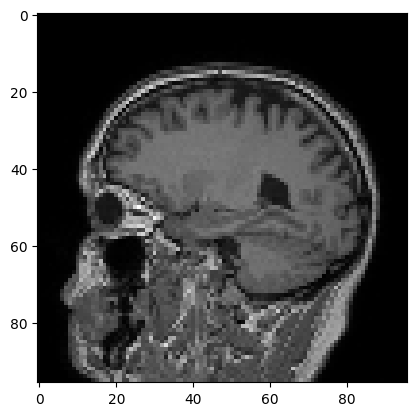

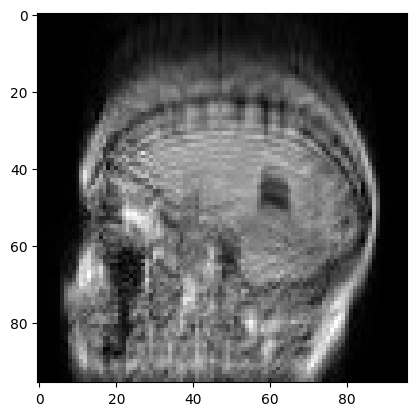

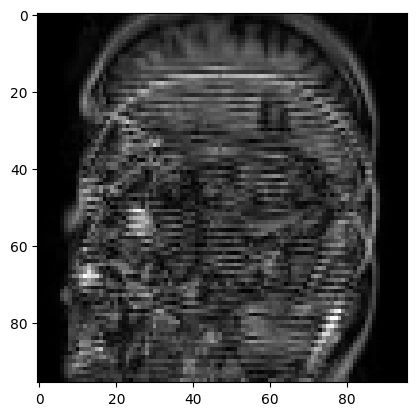

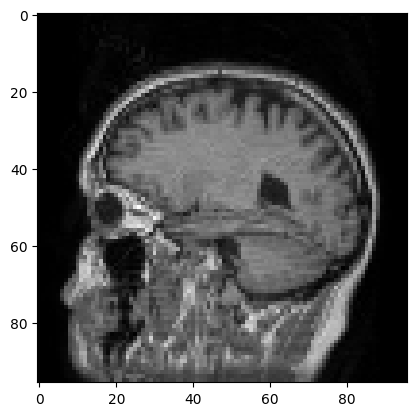

In [3]:
idx = 10

plt.figure()
plt.imshow(data[idx], cmap='gray')

plt.figure()
plt.imshow(torch.abs(final_rxyacq_ROFFT)[idx].numpy(), cmap='gray')

plt.figure()
plt.imshow(torch.abs(torch.matmul(InvA, final_rxyacq_ROFFT)[idx]).numpy(), cmap='gray')

plt.figure()
plt.imshow(torch.abs(torch.matmul(InvA, FinalryxacqROFFTCorr)[idx]).numpy(), cmap='gray')


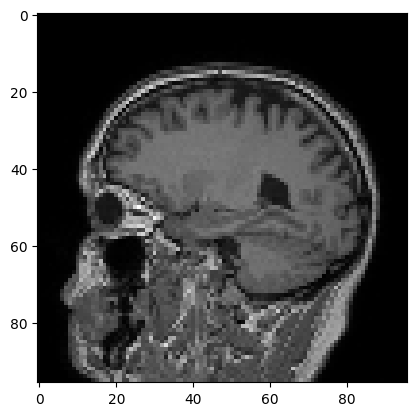

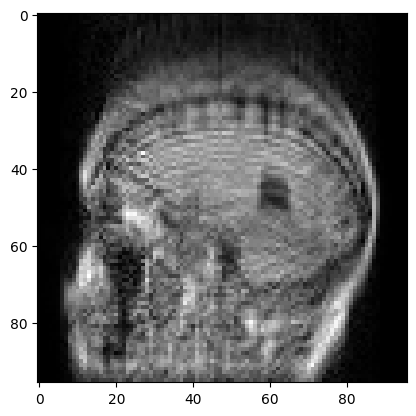

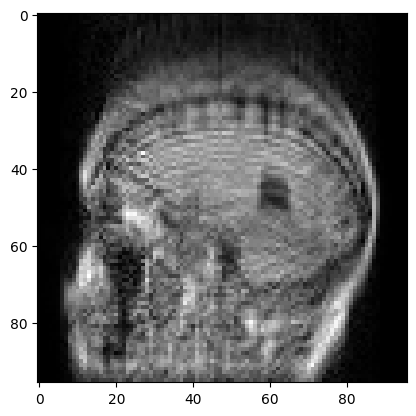

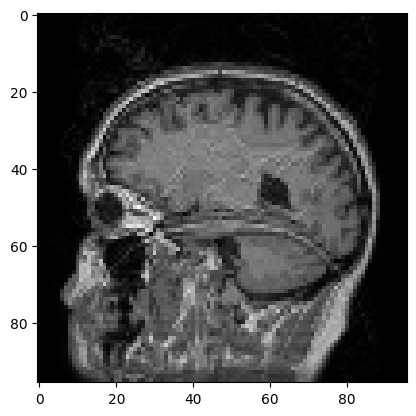

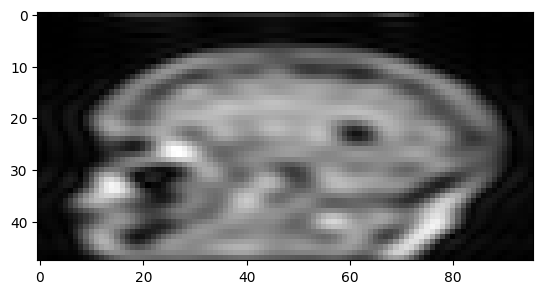

In [4]:
idx = 10

# Degrade image
degraded_data = torch.matmul(AFinal, data * 1j)
blur_data = degraded_data
blur_data[:, 1::2, :] *= torch.exp(1j * phase_map)

# Correct degradation
corr_data = blur_data
corr_data[:, 1::2, :] = corr_data[:, 1::2, :] * torch.exp(-1j * phase_map)
corr_data = torch.matmul(InvA, blur_data)



plt.figure()
plt.imshow(data[idx], cmap='gray')


plt.figure()
plt.imshow(degraded_data[idx].abs(), cmap='gray')

plt.figure()
plt.imshow(blur_data[idx].abs(), cmap='gray')

plt.figure()
plt.imshow(corr_data[idx].abs(), cmap='gray')


plt.figure()
plt.imshow(phase_map[idx].abs(), cmap='gray')